## Задание: 
**А/А-тест проводился с '2024-03-22' по '2024-03-28'. Нужно сделать симуляцию 10000 А/А-тестов, где на  каждой итерации сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-test'ом.**

1. Построить гистограмму распределения получившихся 10000 p-values.
2. Посчитать, какой процент p-values оказался меньше либо равен 0.05.
3. Написать вывод по проведенному А/А-тесту, корректно ли работает система сплитования. При выполнении задания важно обосновать и аргументировать вывод.
4. Прислать ссылку на merge request c проведенным анализом.

p.s. Ключевая метрика - CTR.

In [2]:
import pandahouse 
import pandas as pd
import random 
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
connection = { #здесь были параметры подключения
    'host': "...",
    'password': "...",
    'user': '...',
    'database': "..."
}

In [4]:
q = """
    select exp_group,
           user_id, 
           sum(action='view') as views, 
           sum(action='like') as likes, 
           sum(action='like')/sum(action='view') as ctr
    from {db}.feed_actions
    where date(time) between date('2024-03-22') and date('2024-03-28')
          and exp_group in (2, 3)
    group by user_id, exp_group
"""
df = pandahouse.read_clickhouse(q, connection=connection)

In [5]:
df.groupby('exp_group').count()

,user_id,views,likes,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


In [6]:
sns.set(rc={'figure.figsize':(11.7, 8.27)})

<Axes: xlabel='ctr', ylabel='Count'>

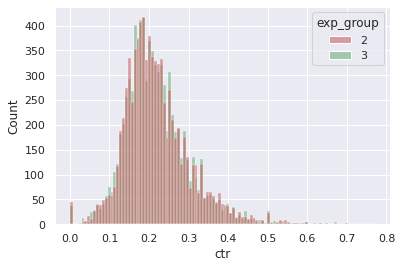

In [7]:
sns.histplot(data=df, x='ctr', hue='exp_group', palette=['r', 'g'], alpha=0.5, kde=False)

In [8]:
p_values, gen_group2, gen_group3 = [], [], []
for _ in range(10000):
    gen_group2 = df[df.exp_group==2].sample(500)
    gen_group3 = df[df.exp_group==3].sample(500)
    test = stats.mannwhitneyu(gen_group2.ctr, gen_group3.ctr)
    p_values.append(test[1])

In [57]:
sns.set(rc={'figure.figsize':(5.5, 5.5)})

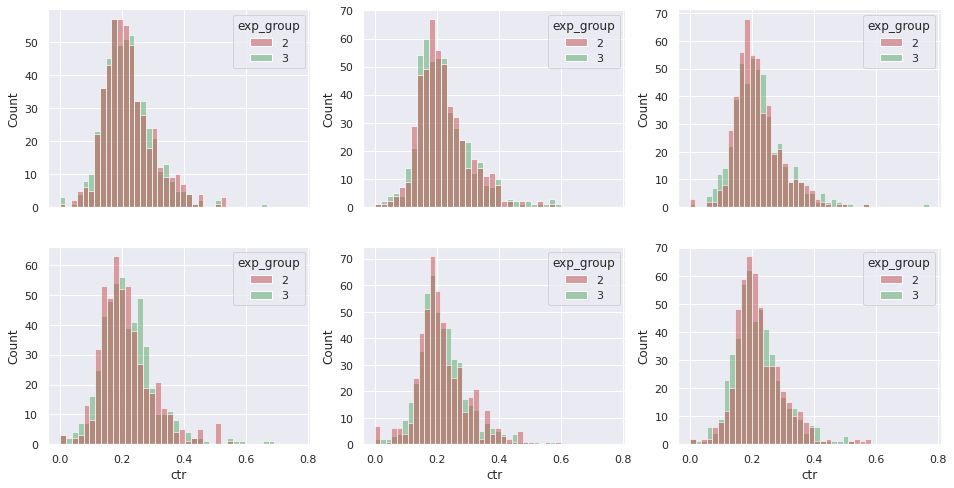

In [9]:
groups, axes = plt.subplots(2, 3, sharex=True, figsize=(16,8)) #визуализация распределения нескольких подвыборок
for i in range(2):
    for j in range(3):
        gen_group2 = df[df.exp_group==2].sample(500)
        gen_group3 = df[df.exp_group==3].sample(500)
        proverka = pd.concat([gen_group2, gen_group3], ignore_index=True)
        groups = sns.histplot(ax=axes[i, j], data=proverka, x='ctr', hue='exp_group', palette=['r', 'g'], alpha=0.5, kde=False)

In [10]:
sns.set(rc={'figure.figsize':(11.7, 8.27)})

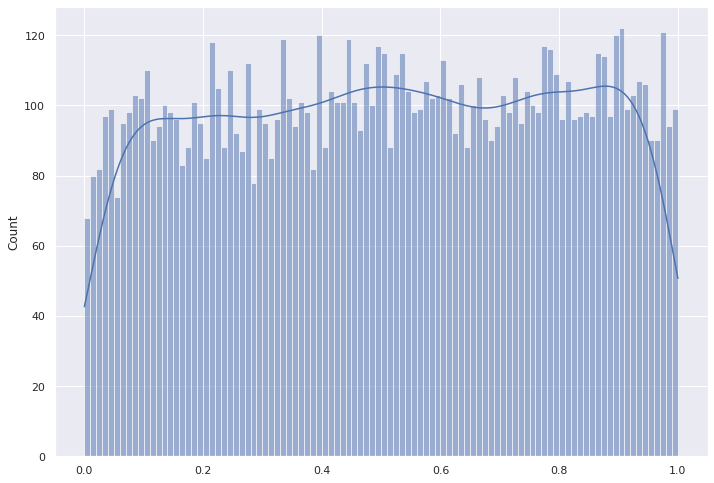

In [11]:
ps = sns.histplot(data=p_values, alpha=0.5, kde=True, bins=100) #визуализация распределения p-values

In [12]:
x = sum([1 if i <= 0.05 else 0 for i in p_values])/len(p_values) * 100 #процент p-values, которые <= 0.05
print(x)

4.22


### Вывод:

**Система сплитования работает корректно**, так как нет значимых различий между тестовой и контрольной группой, поскольку:
1. Тестовая и контрольная группы "похожи месту собой", как минимум, это можно увидеть из самого первого совместного графика с распределением CTR для обоих групп.
2. Многократные А/А тесты на подвыборках показали, что приблизительно в 95% случаев значение pvalue > 0.05, это означает, что нулевую гипотезу (равенство средних в тестовой и контрольной группах, где метрика - CTR) нельзя отклонить, а значит в 95% случаев статистически значимых различий между тестовой и контрольной группами нет.

Из этого следует, что тестовая и контрольная группа идентичны до нашего воздействия, а именно проведения самого А/Б теста.